In [1]:
%%capture
pip install plotly pandas statsmodels kaleido scipy nbformat jinja2

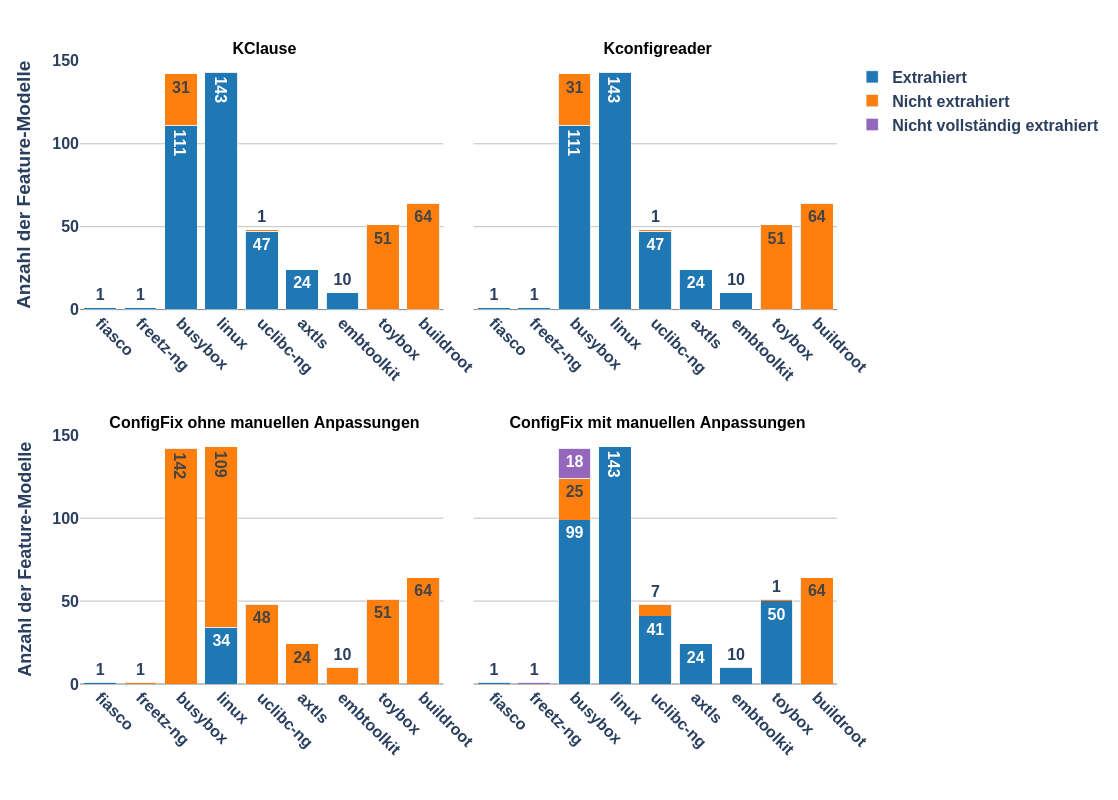

In [766]:
import pandas as pd
import plotly.express as px
import re

# Dateiimport mit Fehlerbehandlung
def import_csv(file_path):
    try:
        return pd.read_csv(file_path)
    except Exception as e:
        print(f"Fehler beim Laden der Datei {file_path}: {e}")
        return pd.DataFrame()

# Funktion zur Konvertierung von Versionsnummern

def parse_version(version):
    try:
        version_cleaned = re.sub(r'release-|v|_', '.', version)
        version_tuple = tuple(map(int, version_cleaned.split('.')))
        return version_tuple + (0,) * (3 - len(version_tuple))
    except:
        return (0, 0, 0)

# Funktion zur Klassifizierung des Fehlerstatus
def error_status(row):
    version_num = parse_version(row['revision'])

    busybox_condition = (
        row['system'].lower() == 'busybox' and
        row['Extractor'] == 'ConfigFix mit manuellen Anpassungen' and
        parse_version("1_5_1") <= version_num <= parse_version("1_9_2")
    )

    freetz_condition = (
        row['system'].lower() == 'freetz-ng' and
        row['Extractor'] == 'ConfigFix mit manuellen Anpassungen' and
        parse_version("5c5a4d1d87ab8c9c6f121a13a8fc4f44c79700af") <= version_num <= parse_version("5c5a4d1d87ab8c9c6f121a13a8fc4f44c79700af")
    )

    if busybox_condition or freetz_condition:
        return 'Nicht vollständig extrahiert'

    return 'Extrahiert' if pd.notna(row['model-file']) else 'Nicht extrahiert'

# Funktion zur Status-Bestimmung
def model_status(row):
    return 'Extrahierte Feature-Modelle' if pd.notna(row['model-file']) else 'Nicht extrahierte Feature-Modelle'

# Dateien einlesen und verarbeiten
def process_data(file_paths, extractor_names):
    dataframes = []
    for file, extractor in zip(file_paths, extractor_names):
        df = import_csv(file)[['system', 'revision', 'model-file']].copy()
        df['Extractor'] = extractor
        dataframes.append(df)
    
    df_combined = pd.concat(dataframes, ignore_index=True)
    df_combined['error_status'] = df_combined.apply(error_status, axis=1)
    df_combined['status'] = df_combined.apply(model_status, axis=1)

    return df_combined

# Datei- und Extractor-Pfade
file_paths = [
    '/home/rami/Downloads/kmax/kconfig/output.csv',
    '/home/rami/Downloads/Kconfigreader/kconfig/output.csv',
    '/home/rami/Downloads/configFixextractor/kconfig/output.csv',
    '/home/rami/Downloads/configFixextractor_with_preprossesing/kconfig/output.csv'
]

extractor_names = [
    'KClause', 'Kconfigreader',
    'ConfigFix ohne manuellen Anpassungen', 'ConfigFix mit manuellen Anpassungen'
]

df_combined = process_data(file_paths, extractor_names)

# Zusammenfassung für Diagramm
df_summary_combined = df_combined.groupby(['system', 'status', 'Extractor', 'error_status']) \
                                 .size().reset_index(name='count')

# Reihenfolge der Extraktoren anpassen
df_summary_combined['Extractor'] = pd.Categorical(df_summary_combined['Extractor'], 
    categories=['KClause', 'Kconfigreader', 'ConfigFix ohne manuellen Anpassungen', 'ConfigFix mit manuellen Anpassungen'], ordered=True)
df_summary_combined.sort_values('Extractor', inplace=True)

# Visualisierung
fig_combined = px.bar(
    df_summary_combined,
    x='system',
    y='count',
    color='error_status',
    facet_col='Extractor',
    facet_col_wrap=2,  # Zwei oben, zwei unten
    labels={'count': 'Anzahl der Feature-Modelle', 'system': '', 'status': 'Extraktionsstatus'},
    text='count',
    color_discrete_map={
        'Extrahiert': '#1F77B4',
        'Nicht vollständig extrahiert': '#9467BD',
        'Nicht extrahiert': '#FF7F0E'
    },
    facet_col_spacing=0.04,
    facet_row_spacing=0.2,
    height=800  # Anpassung der Diagrammhöhe
)

# Layout anpassen
fig_combined.update_layout(
    font=dict(size=16, weight='bold'),
    legend_title='',
    barmode='stack',
    plot_bgcolor='white',
    paper_bgcolor='white',
    yaxis=dict(
        title='Anzahl der Feature-Modelle',
        showticklabels=True,
        title_font=dict(size=18, weight='bold'),
    ),
    xaxis=dict(
        title='',
        showticklabels=True
    ),
    title_x=0.5,
    title={'text': '', 'x': 0.5, 'xanchor': 'center'}
)

fig_combined.update_traces(textfont=dict(size=16, family='Arial', weight='bold'), texttemplate='<b>%{text}</b>')

# Einheitliche X-Achse-Beschriftungen (inkl. obere Diagramme explizit aktivieren)
fig_combined.for_each_xaxis(lambda xaxis: xaxis.update(tickangle=45, showticklabels=True))
fig_combined.update_yaxes(
    showgrid=True,
    gridcolor='gray',
    gridwidth=0.5,
    zeroline=True,
    zerolinecolor='gray',
    zerolinewidth=1,
    rangemode='tozero',
    mirror=True
)

# Facetten Titel anpassen
fig_combined.for_each_annotation(lambda a: a.update(text=f" {a.text.split('=')[-1]}", font_size=16, font_color="black", font_weight='bold'))

# Diagramm anzeigen
fig_combined.show()


+----+---------------+---------+---------+----------+-------+-------+--------+--------+-----------+
|    | Extractor     |   count |    mean |      std |   min |   25% |    50% |    75% |       max |
+====+===============+=========+=========+==========+=======+=======+========+========+===========+
|  0 | ConfigFix-MMA |     483 |  18.898 |   15.293 | 0.146 | 5.308 | 14.196 | 31.143 |    50.157 |
+----+---------------+---------+---------+----------+-------+-------+--------+--------+-----------+
|  1 | ConfigFix-OMA |     458 |  17.485 |   42.441 | 0.141 | 2.948 |  6.268 | 12.255 |   270.684 |
+----+---------------+---------+---------+----------+-------+-------+--------+--------+-----------+
|  2 | KClause       |     483 | 115.439 | 2143.47  | 0.229 | 0.719 |  2.591 | 12.954 | 47119.3   |
+----+---------------+---------+---------+----------+-------+-------+--------+--------+-----------+
|  3 | Kconfigreader |     452 |   7.071 |   24.33  | 0.216 | 0.615 |  1.515 |  3.567 |   274.637 |


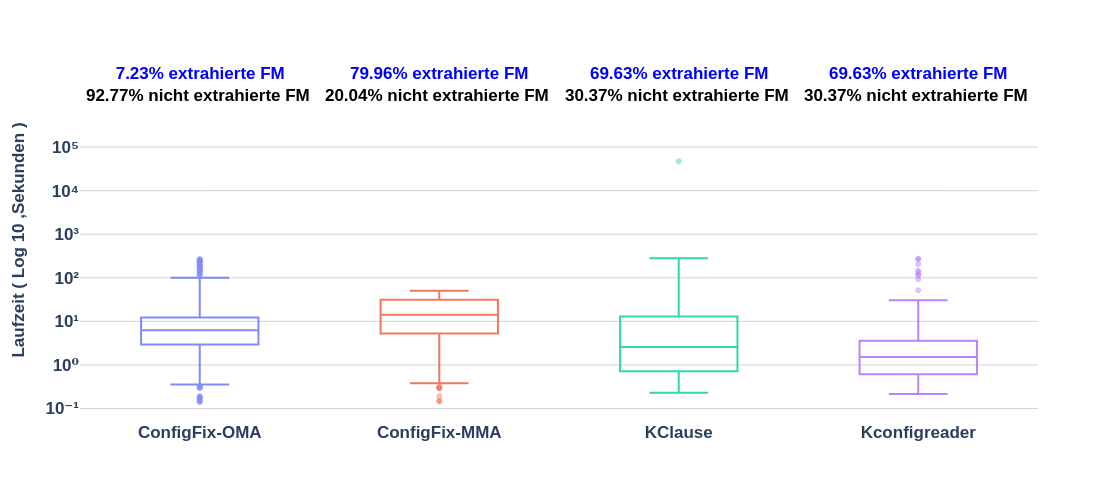

Farbzuweisung für Extractor:
ConfigFix-OMA: #636EFA
ConfigFix-MMA: #EF553B
KClause: #00CC96
Kconfigreader: #AB63FA


In [4]:
#FF2: Alle System und Tools
import pandas as pd
import plotly.express as px
from math import log10, floor

# Dateipfade (bitte entsprechend anpassen!)
file_configfixextractor_with_preprossesing = '/home/rami/Downloads/configFixextractor_with_preprossesing/kconfig/output.csv'
file_kmax = '/home/rami/Downloads/kmax/kconfig/output.csv'
file_Kconfigreader = '/home/rami/Downloads/Kconfigreader/kconfig/output.csv'
file_configfixextractor ='/home/rami/Downloads/configFixextractor/kconfig/output.csv'

# CSV-Dateien laden und Extractor-Spalte hinzufügen
df_configfixextractor_with_preprossesing = pd.read_csv(file_configfixextractor_with_preprossesing).assign(Extractor='ConfigFix-MMA')
df_configfixextractor = pd.read_csv(file_configfixextractor).assign(Extractor='ConfigFix-OMA')
df_kmax = pd.read_csv(file_kmax).assign(Extractor='KClause')
df_Kconfigreader = pd.read_csv(file_Kconfigreader).assign(Extractor='Kconfigreader')

# Zusammenführen der DataFrames
df_combined = pd.concat([
    df_configfixextractor[['system', 'revision', 'model-file', 'Extractor', 'model-time']],
    df_configfixextractor_with_preprossesing[['system', 'revision', 'model-file', 'Extractor', 'model-time']],
    df_kmax[['system', 'revision', 'model-file', 'Extractor', 'model-time']],
    df_Kconfigreader[['system', 'revision', 'model-file', 'Extractor', 'model-time']]
], ignore_index=True)

# Umwandlung von 'model-time' von Nanosekunden in ganze Sekunden (mit Behandlung von NaN-Werten)
df_combined['model-time-seconds'] =   df_combined['model-time'].apply(lambda x: x / 1_000_000_000 if pd.notna(x) else pd.NA)

def big_log10(val):
    return log10(val) if pd.notna(val) and val > 0 else pd.NA

df_combined['log_model_time'] = df_combined['model-time-seconds'].apply(big_log10)

df_combined['extracted'] = df_combined['model-file'].notna()
percent_stats = df_combined.groupby(['Extractor', 'extracted']).size().unstack(fill_value=0)
percent_stats['total'] = percent_stats.sum(axis=1)
percent_stats['extracted_percent'] = round((percent_stats[True] / percent_stats['total']) * 100, 2)
percent_stats['not_extracted_percent'] = round((percent_stats[False] / percent_stats['total']) * 100, 2)

# Boxplot zur Visualisierung der Modell-Zeiten nach Extractor mit logarithmischer Skala
fig_boxplot = px.box(
    df_combined,
    x='Extractor',
    y='log_model_time',
    color='Extractor',
    points='outliers',
    height=800 ,
    labels={'model-time-seconds': 'Modell-Zeit (Sekunden)'}
)

# Prozentwerte als Legende in Blau und Schwarz einfügen
legend_text = [
    f"<span style='color:blue'>{row['extracted_percent']}% extrahierte FM</span><br>"
    f"<span style='color:black'>{row['not_extracted_percent']}% nicht extrahierte FM </span>"
    for idx, row in percent_stats.iterrows()
]

for idx, text in zip(percent_stats.index, legend_text):
    fig_boxplot.add_annotation(
        x=idx,
        y=6,  # Position der Werte über den Boxplots
        text=text,
        showarrow=False,
        yshift=20
    )

fig_boxplot.update_traces(fillcolor='rgba(255,255,255,0)', opacity=0.8)
# Layout anpassen
fig_boxplot.update_traces(marker=dict(size=6, opacity=0.5))
fig_boxplot.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(size=17, family='Arial', weight='bold'),
    yaxis_title='Laufzeit ( Log 10 ,Sekunden )',
    xaxis_title='',
    title_x=0.5,
    yaxis=dict(
        title_font=dict(size=17, family='Arial', weight='bold'),
        tickvals=[-1, 0, 1, 2, 3, 4, 5],
        ticktext=['10⁻¹', '10⁰', '10¹', '10²', '10³', '10⁴', '10⁵'],
        showgrid=True,
        showline=False,
        linecolor='black',
        linewidth=0.5,
        zeroline=True,      # Erzwinge die Anzeige der Null-Linie
        zerolinewidth=1, 
        zerolinecolor='lightgray',
        gridcolor='lightgray'
    ),
    xaxis=dict(title_font=dict(size=17, family='Arial', weight='bold'),showgrid=False, showline=False, linecolor='black', linewidth=0.5),
    showlegend=False,
    height=500
)

# Stelle sicher, dass 'model-time-seconds' numerisch ist
df_combined['model-time-seconds'] = pd.to_numeric(df_combined['model-time-seconds'], errors='coerce')

# Dann: Statistik auf numerischer Spalte
summary_stats = df_combined.groupby('Extractor')['model-time-seconds'].describe(percentiles=[0.25, 0.5, 0.75]).reset_index()

# Rundung für schöne Ausgabe
summary_stats = summary_stats.round(3)

from tabulate import tabulate
print(tabulate(summary_stats, headers='keys', tablefmt='grid'))

# Diagramm anzeigen
fig_boxplot.show()

#print(df_combined)

# Farben der einzelnen Kategorien extrahieren
color_map = px.colors.qualitative.Plotly  # Standard-Plotly-Farben
extractors = df_combined['Extractor'].unique()

# Farben jeder Kategorie zuweisen
color_dict = {extractor: color_map[i % len(color_map)] for i, extractor in enumerate(extractors)}

# Farben anzeigen
print("Farbzuweisung für Extractor:")
for extractor, color in color_dict.items():
    print(f"{extractor}: {color}")


+----+---------------+---------+----------+----------+--------+---------+---------+---------+-----------+
|    | Extractor     |   count |     mean |      std |    min |     25% |     50% |     75% |       max |
+====+===============+=========+==========+==========+========+=========+=========+=========+===========+
|  0 | ConfigFix-MMA |      35 |   23.778 |    1.941 | 20.699 |  22.056 |  23.905 |  25.479 |    27.16  |
+----+---------------+---------+----------+----------+--------+---------+---------+---------+-----------+
|  1 | ConfigFix-OMA |      35 |  144.599 |   76.528 | 19.271 |  81.39  | 145.767 | 207.957 |   270.684 |
+----+---------------+---------+----------+----------+--------+---------+---------+---------+-----------+
|  2 | KClause       |      35 | 1457.15  | 7945.41  |  0.694 | 100.178 | 108.511 | 112.551 | 47119.3   |
+----+---------------+---------+----------+----------+--------+---------+---------+---------+-----------+
|  3 | Kconfigreader |      35 |   48.031 |   

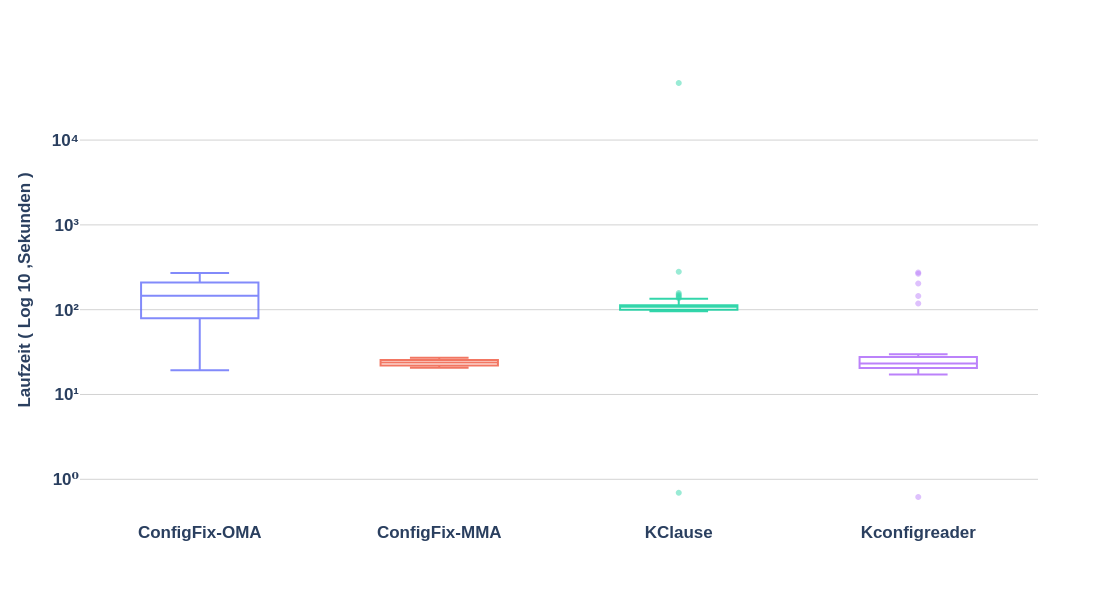

In [5]:
#FF2: Alle Systeme, die gleichzeitig von allen Tools extrahiert wurden
import pandas as pd
import plotly.express as px
from math import log10, floor

# Dateipfade (bitte entsprechend anpassen!)
file_configfixextractor_with_preprossesing = '/home/rami/Downloads/configFixextractor_with_preprossesing/kconfig/output.csv'
file_kmax = '/home/rami/Downloads/kmax/kconfig/output.csv'
file_Kconfigreader = '/home/rami/Downloads/Kconfigreader/kconfig/output.csv'
file_configfixextractor ='/home/rami/Downloads/configFixextractor/kconfig/output.csv'

# CSV-Dateien laden und Extractor-Spalte hinzufügen
df_configfixextractor_with_preprossesing = pd.read_csv(file_configfixextractor_with_preprossesing).assign(Extractor='ConfigFix-MMA')
df_configfixextractor = pd.read_csv(file_configfixextractor).assign(Extractor='ConfigFix-OMA')
df_kmax = pd.read_csv(file_kmax).assign(Extractor='KClause')
df_Kconfigreader = pd.read_csv(file_Kconfigreader).assign(Extractor='Kconfigreader')

# Zusammenführen der DataFrames
df_combined = pd.concat([
    df_configfixextractor[['system', 'revision', 'model-file', 'Extractor', 'model-time']],
    df_configfixextractor_with_preprossesing[['system', 'revision', 'model-file', 'Extractor', 'model-time']],
    df_kmax[['system', 'revision', 'model-file', 'Extractor', 'model-time']],
    df_Kconfigreader[['system', 'revision', 'model-file', 'Extractor', 'model-time']]
], ignore_index=True)

# Filter für Systeme, die von allen Tools extrahiert wurden
df_filtered = df_combined.groupby(['system', 'revision']).filter(
    lambda x: (len(x) == 4) and all(pd.notna(x['model-file']))
)

# Umwandlung von 'model-time' von Nanosekunden in ganze Sekunden (mit Behandlung von NaN-Werten)
df_filtered['model-time-seconds'] = df_filtered['model-time'].apply(lambda x: x / 1_000_000_000 if pd.notna(x) else pd.NA)

def big_log10(val):
    return log10(val) if pd.notna(val) and val > 0 else pd.NA

df_filtered['log_model_time'] = df_filtered['model-time-seconds'].apply(big_log10)

# Boxplot zur Visualisierung der Modell-Zeiten nach Extractor mit logarithmischer Skala
fig_boxplot = px.box(
    df_filtered,
    x='Extractor',
    y='log_model_time',
    color='Extractor',
    points='outliers',
    height=800,
    labels={'model-time-seconds': 'Modell-Zeit (Sekunden)'}
)

fig_boxplot.update_traces(fillcolor='rgba(255,255,255,0)', opacity=0.8)
# Layout anpassen
fig_boxplot.update_traces(marker=dict(size=6, opacity=0.5))
fig_boxplot.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(size=17, family='Arial', weight='bold'),
    yaxis_title='Laufzeit ( Log 10 ,Sekunden )',
    xaxis_title='',
    title_x=0.5,
    yaxis=dict(
        title_font=dict(size=17, family='Arial', weight='bold'),
        tickvals=[-1, 0, 1, 2, 3, 4, 5],
        ticktext=['10⁻¹', '10⁰', '10¹', '10²', '10³', '10⁴', '10⁵'],
        showgrid=True,
        showline=False,
        linecolor='black',
        linewidth=0.5,
        zeroline=True,      # Erzwinge die Anzeige der Null-Linie
        zerolinewidth=1, 
        zerolinecolor='lightgray',
        gridcolor='lightgray'
    ),
    xaxis=dict(title_font=dict(size=17, family='Arial', weight='bold'),showgrid=False, showline=False, linecolor='black', linewidth=0.5),
    showlegend=False,
    height=600
)

# Stelle sicher, dass 'model-time-seconds' numerisch ist
df_filtered['model-time-seconds'] = pd.to_numeric(df_filtered['model-time-seconds'], errors='coerce')

# Dann: Statistik auf numerischer Spalte
summary_stats = df_filtered.groupby('Extractor')['model-time-seconds'].describe(percentiles=[0.25, 0.5, 0.75]).reset_index()

# Rundung für schöne Ausgabe
summary_stats = summary_stats.round(3)

from tabulate import tabulate
print(tabulate(summary_stats, headers='keys', tablefmt='grid'))

# Diagramm anzeigen
fig_boxplot.show()

# Zeilen ausgeben, die den Extractor 'KClause' enthalten
#print(df_filtered[df_filtered['Extractor'] == 'KClause'])




+----+---------------+---------+---------+----------+-------+-------+--------+--------+-----------+
|    | Extractor     |   count |    mean |      std |   min |   25% |    50% |    75% |       max |
+====+===============+=========+=========+==========+=======+=======+========+========+===========+
|  0 | ConfigFix-MMA |     331 |  22.932 |   15.289 | 0.292 | 8.173 | 21.498 | 36.713 |    50.157 |
+----+---------------+---------+---------+----------+-------+-------+--------+--------+-----------+
|  1 | KClause       |     331 | 168.234 | 2588.79  | 0.693 | 2.557 |  3.384 | 31.647 | 47119.3   |
+----+---------------+---------+---------+----------+-------+-------+--------+--------+-----------+
|  2 | Kconfigreader |     331 |   9.511 |   28.047 | 0.613 | 1.368 |  1.948 |  6.913 |   274.637 |
+----+---------------+---------+---------+----------+-------+-------+--------+--------+-----------+


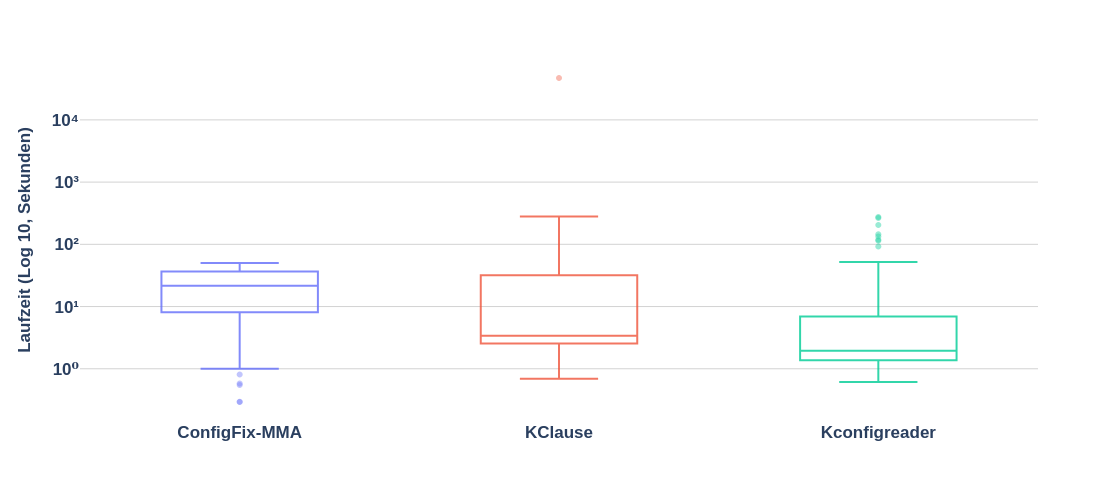

In [6]:
#FF2: Alle Systeme, die gleichzeitig von allen Tools extrahiert wurden
import pandas as pd
import plotly.express as px
from math import log10, floor

# Dateipfade (bitte entsprechend anpassen!)
file_configfixextractor_with_preprossesing = '/home/rami/Downloads/configFixextractor_with_preprossesing/kconfig/output.csv'
file_kmax = '/home/rami/Downloads/kmax/kconfig/output.csv'
file_Kconfigreader = '/home/rami/Downloads/Kconfigreader/kconfig/output.csv'


# CSV-Dateien laden und Extractor-Spalte hinzufügen
df_configfixextractor_with_preprossesing = pd.read_csv(file_configfixextractor_with_preprossesing).assign(Extractor='ConfigFix-MMA')
df_kmax = pd.read_csv(file_kmax).assign(Extractor='KClause')
df_Kconfigreader = pd.read_csv(file_Kconfigreader).assign(Extractor='Kconfigreader')

# Zusammenführen der DataFrames
df_combined = pd.concat([
    df_configfixextractor_with_preprossesing[['system', 'revision', 'model-file', 'Extractor', 'model-time']],
    df_kmax[['system', 'revision', 'model-file', 'Extractor', 'model-time']],
    df_Kconfigreader[['system', 'revision', 'model-file', 'Extractor', 'model-time']]
], ignore_index=True)
#df_combined = df_combined[~df_combined['system'].isin(['fiasco', 'freetz-ng'])]
# Filter für Systeme, die von allen Tools extrahiert wurden
df_filtered = df_combined.groupby(['system', 'revision']).filter(
    lambda x: (len(x) == 3) and all(pd.notna(x['model-file']))
)

# Umwandlung von 'model-time' von Nanosekunden in ganze Sekunden (mit Behandlung von NaN-Werten)
df_filtered['model-time-seconds'] = df_filtered['model-time'].apply(lambda x: x / 1_000_000_000 if pd.notna(x) else pd.NA)

def big_log10(val):
    return log10(val) if pd.notna(val) and val > 0 else pd.NA

df_filtered['log_model_time'] = df_filtered['model-time-seconds'].apply(big_log10)

# Boxplot zur Visualisierung der Modell-Zeiten nach Extractor mit logarithmischer Skala
fig_boxplot = px.box(
    df_filtered,
    x='Extractor',
    y='log_model_time',
    color='Extractor',
    points='outliers',
    height=800,
    labels={'model-time-seconds': 'Modell-Zeit (Sekunden)'}
)

fig_boxplot.update_traces(fillcolor='rgba(255,255,255,0)', opacity=0.8)
# Layout anpassen
fig_boxplot.update_traces(marker=dict(size=6, opacity=0.5))
fig_boxplot.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(size=17, family='Arial', weight='bold'),
    yaxis_title='Laufzeit (Log 10, Sekunden)',
    xaxis_title='',
    title_x=0.5,
    yaxis=dict(
        title_font=dict(size=17, family='Arial', weight='bold'),
        tickvals=[-1, 0, 1, 2, 3, 4, 5],
        ticktext=['10⁻¹', '10⁰', '10¹', '10²', '10³', '10⁴', '10⁵'],
        showgrid=True,
        showline=False,
        linecolor='black',
        linewidth=0.5,
        zeroline=True,      # Erzwinge die Anzeige der Null-Linie
        zerolinewidth=1,
        zerolinecolor='lightgray',
        gridcolor='lightgray'
    ),
    xaxis=dict(title_font=dict(size=17, family='Arial', weight='bold'), showgrid=False, showline=False, linecolor='black', linewidth=0.5),
    showlegend=False,
    height=500
)

# Stelle sicher, dass 'model-time-seconds' numerisch ist
df_filtered['model-time-seconds'] = pd.to_numeric(df_filtered['model-time-seconds'], errors='coerce')

# Dann: Statistik auf numerischer Spalte
summary_stats = df_filtered.groupby('Extractor')['model-time-seconds'].describe(percentiles=[0.25, 0.5, 0.75]).reset_index()

# Rundung für schöne Ausgabe
summary_stats = summary_stats.round(3)

from tabulate import tabulate
print(tabulate(summary_stats, headers='keys', tablefmt='grid'))

# Diagramm anzeigen
fig_boxplot.show()

#print(df_filtered)


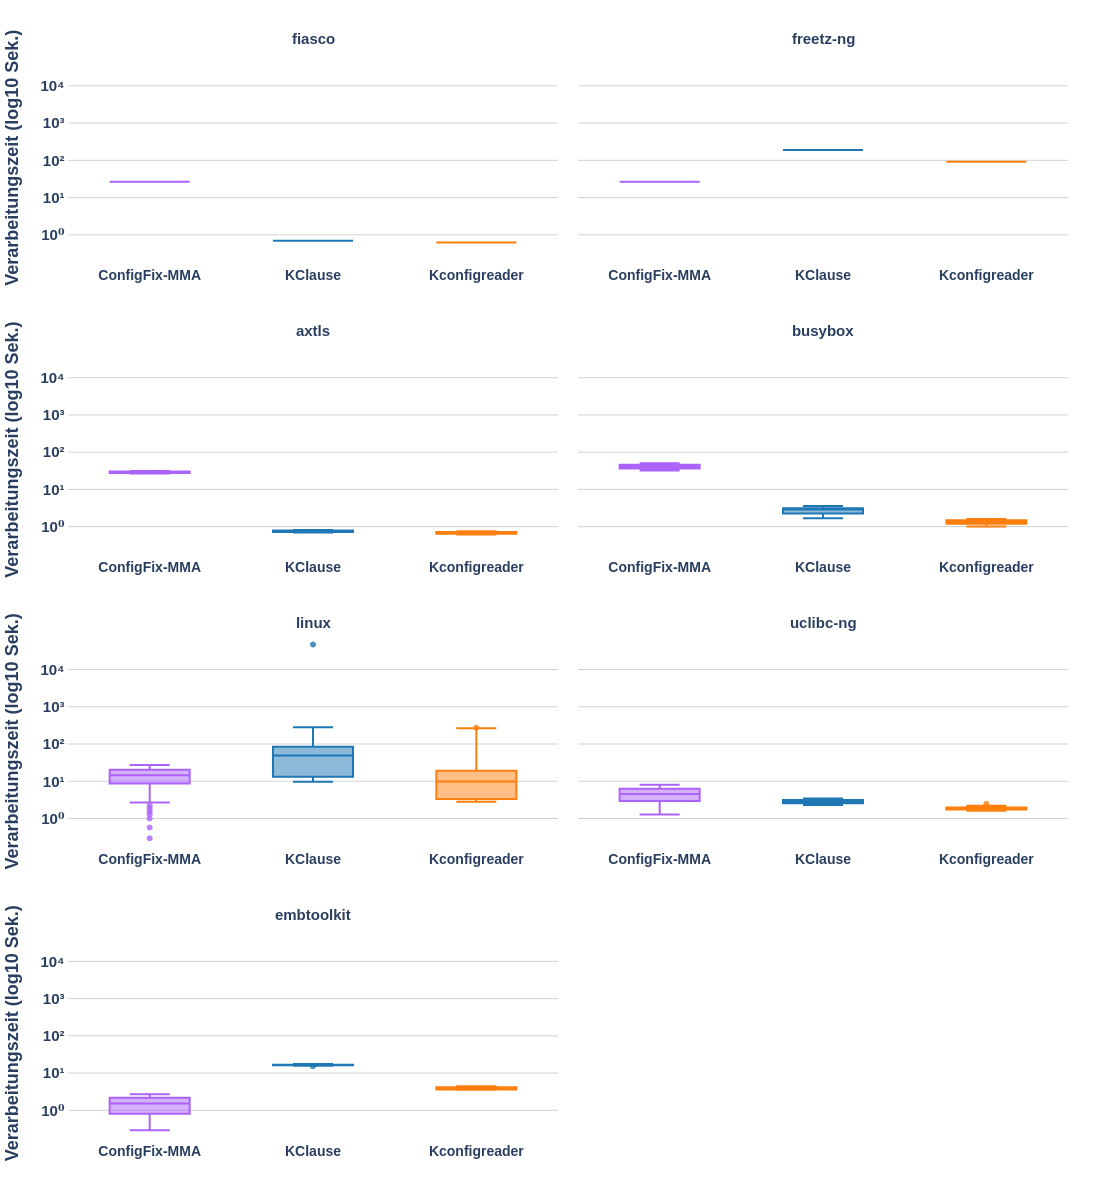


📊 Statistiken für System: axtls
+----+----------+---------------+---------+--------+-------+--------+--------+--------+--------+--------+
|    | system   | Extractor     |   count |   mean |   std |    min |    25% |    50% |    75% |    max |
+====+==========+===============+=========+========+=======+========+========+========+========+========+
|  0 | axtls    | ConfigFix-MMA |      24 | 28.913 | 1.376 | 26.813 | 27.756 | 28.859 | 30.045 | 31.143 |
+----+----------+---------------+---------+--------+-------+--------+--------+--------+--------+--------+
|  1 | axtls    | KClause       |      24 |  0.757 | 0.039 |  0.693 |  0.72  |  0.767 |  0.79  |  0.812 |
+----+----------+---------------+---------+--------+-------+--------+--------+--------+--------+--------+
|  2 | axtls    | Kconfigreader |      24 |  0.686 | 0.045 |  0.613 |  0.645 |  0.697 |  0.72  |  0.757 |
+----+----------+---------------+---------+--------+-------+--------+--------+--------+--------+--------+

📊 Statistike

In [8]:
import pandas as pd
import plotly.express as px
from math import log10

# Hilfsfunktion zur Logarithmustransformation
def big_log10(val):
    return log10(val) if pd.notna(val) and val > 0 else pd.NA

# Dateipfade (bitte entsprechend anpassen!)
file_configfixextractor = '/home/rami/Downloads/configFixextractor_with_preprossesing/kconfig/output.csv'
file_kmax = '/home/rami/Downloads/kmax/kconfig/output.csv'
file_Kconfigreader = '/home/rami/Downloads/Kconfigreader/kconfig/output.csv'

# CSV-Dateien laden und Extractor-Spalte hinzufügen
df_configfixextractor = pd.read_csv(file_configfixextractor).assign(Extractor='ConfigFix-MMA')
df_kmax = pd.read_csv(file_kmax).assign(Extractor='KClause')
df_Kconfigreader = pd.read_csv(file_Kconfigreader).assign(Extractor='Kconfigreader')

#df_combined = df_combined[~df_combined['system'].isin(['fiasco', 'freetz-ng'])]
# Zusammenführen der DataFrames
df_combined = pd.concat([
    df_configfixextractor[['system', 'revision', 'model-file', 'Extractor', 'model-time']],
    df_kmax[['system', 'revision', 'model-file', 'Extractor', 'model-time']],
    df_Kconfigreader[['system', 'revision', 'model-file', 'Extractor', 'model-time']]
], ignore_index=True)

# Sicherstellen, dass 'model-time' numerisch ist
df_combined['model-time'] = pd.to_numeric(df_combined['model-time'], errors='coerce')

# Zeiten in Sekunden umwandeln
df_combined['model-time-seconds'] = df_combined['model-time'] / 1e9

# Nur Systeme und Revisionen behalten, die von allen drei Tools extrahiert wurden
pivot_df = df_combined.pivot_table(index=['system', 'revision'], columns='Extractor', values='model-file', aggfunc='first')
valid_cases = pivot_df.dropna().reset_index()[['system', 'revision']]

df_valid = pd.merge(df_combined, valid_cases, on=['system', 'revision'], how='inner')

# Logarithmus der Verarbeitungszeit berechnen
df_combined['log_model_time'] = df_combined['model-time-seconds'].apply(big_log10)
df_valid = df_combined.merge(valid_cases, on=['system', 'revision'], how='inner')

# Boxplot erstellen für jedes System
fig_box = px.box(
    df_valid,
    x='Extractor',
    y='log_model_time',
    color='Extractor',
    facet_col='system',
    facet_col_wrap=2,  # 2 Spalten und 4 Zeilen
    labels={'log_model_time': 'Verarbeitungszeit (log10 Sek.)', 'Extractor': 'Extractor'},
    title='',
    color_discrete_map={
        'Configfixextractor': '#9467BD',
        'KClause': '#1F77B4',
        'Kconfigreader': '#FF7F0E'
    },
    height=1600  # Erhöhte Höhe für größeren Abstand
)

# Layout optimieren
fig_box.update_traces(marker=dict(opacity=0.8))

fig_box.update_yaxes(
    showgrid=True, 
    showline=True, 
    #linecolor='black', 
    linewidth=0.5, 
    gridcolor='lightgray',
    zeroline=True,      
    zerolinewidth=1,
    zerolinecolor='lightgray',
    tickmode='array',
    tickvals=[-1, 0, 1, 2, 3, 4, 5],
    ticktext=['10⁻¹', '10⁰', '10¹', '10²', '10³', '10⁴', '10⁵'],
)
fig_box.update_xaxes(
    showticklabels=True,tickfont=dict(size=14, family='Arial', weight='bold'))

# Text im Diagramm lesbarer machen
fig_box.for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1]))

fig_box.update_layout(
    plot_bgcolor='white',
    paper_bgcolor='white',
    font=dict(size=15, family='Arial', weight='bold'),
    yaxis_title='Verarbeitungszeit (log10 Sek.)',
    xaxis_title='',
    height=1200,  # Höhere Diagrammhöhe für bessere Übersicht
    width=800,    # Breitere Darstellung für weniger Überlappung
    margin=dict(t=50, b=50, l=50, r=50),
    showlegend=False
    
)

# Diagramm anzeigen
fig_box.show()

# Gruppiere nach System und Extractor
summary_per_system = (
    df_valid
    .groupby(['system', 'Extractor'])['model-time-seconds']
    .describe(percentiles=[0.25, 0.5, 0.75])
    .reset_index()
    .round(3)
)

# Ausgabe als Tabelle pro System
systems = summary_per_system['system'].unique()

from tabulate import tabulate

for sys in systems:
    print(f"\n📊 Statistiken für System: {sys}")
    system_stats = summary_per_system[summary_per_system['system'] == sys]
    print(tabulate(system_stats, headers='keys', tablefmt='grid'))


In [139]:

import glob
import re
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import pandas as pd
import numpy as np
import os.path
import pickle
import scipy
from statistics import mean, stdev
from math import sqrt, log10
from packaging.version import Version
from itertools import combinations

#output_directory = '../output-linux'
output_directory = '/home/rami/Dokumente/data'
figures_directory = '../../paper-tosem-2024-linux/tosem-2024/figures'
default_height = 270

pio.templates['colorblind'] = go.layout.Template(layout_colorway=['#648FFF', '#FE6100', '#785EF0', '#DC267F', '#FFB000'])
pio.templates.default = 'plotly_white+colorblind'

def read_dataframe(extractor,system,stage, dtype={}, usecols=None, file=None):
    if not file:
        file = 'output'
    df = pd.read_csv(f'{output_directory}/{extractor}/{system}/{stage}/{file}.csv', dtype=dtype, usecols=usecols)
    return df

def replace_values(df):
    df.replace('kconfigreader', 'KConfigReader', inplace=True)
    df.replace('kmax', 'KClause', inplace=True)
    df.replace('configfixextractor', 'ConfigFix', inplace=True)

def big_log10(str):
    return log10(int(str)) if not pd.isna(str) and str != '' else pd.NA

def process_model_count(df_solve):
    df_solve['model-count'] = df_solve['model-count'].replace('1', '')
    df_solve['model-count-log10'] = df_solve['model-count'].fillna('').apply(big_log10).replace(0, np.nan)

def read_dataframe_configs(extractor, system, dtype={}, file='output'):
    path = f'{output_directory}/{extractor}/{system}/read-{system}-configs/{file}.csv'
    if os.path.exists(path):
        df = pd.read_csv(path, dtype=dtype)
        df = df[~df['kconfig-file'].str.contains('/um/')]
        return df
    else:
        print(f"⚠️ Datei nicht gefunden: {path}")
        return None


def read_dataframe_configs_type(extractor, system, dtype={}, file='output.types'):
    path = f'{output_directory}/{extractor}/{system}/read-{system}-configs/{file}.csv'
    if os.path.exists(path):
        df = pd.read_csv(path, dtype=dtype)
        df = df[~df['kconfig-file'].str.contains('/um/')]
        return df
    else:
        print(f"⚠️ Datei nicht gefunden: {path}")
        return None

In [243]:
extractor_comparison = {}

def jaccard(a, b):
    return len(set.intersection(a, b)) / len(set.union(a, b))

def add_features(descriptor, source, features, min=2):
    descriptor[f'#{source}'] = len(features) if features is not None and len(features) >= min else np.nan

def get_variables(variable_map):
    variables = set(variable_map.values())
    if len(variables) <= 1:
        variables = set()
    return variables

def read_unconstrained_feature_variables(extractor, system , revision):
    unconstrained_features_filename = f'{output_directory}/{extractor}/{system}/unconstrained-features/{system}/{revision}.unconstrained.features'
    unconstrained_feature_variables = set()
    if os.path.isfile(unconstrained_features_filename):
        with open(unconstrained_features_filename, 'r') as f:
            unconstrained_feature_variables = set([re.sub('^CONFIG_', '', f.strip()) for f in f.readlines()])
    return unconstrained_feature_variables


def inspect_system_features_for_model(extractor, system, revision, config_features, features_for_last_revision):

    features_filename = f'{output_directory}/{extractor}/{system}/kconfig/{system}/{revision}.features'
    with open(features_filename, 'r') as f:
        extracted_features = set([re.sub('^CONFIG_', '', f.strip()) for f in f.readlines()])
    
    unconstrained_feature_variables = read_unconstrained_feature_variables(extractor, system , revision)

    dimacs_filename = f'{output_directory}/{extractor}/{system}/backbone-dimacs/{system}/{revision}.backbone.dimacs'
    all_variables = set()
    variables = set()
    feature_variables = set()
    core_feature_variables = set()
    dead_feature_variables = set()
    undead_feature_variables = set()
    all_feature_variables = set()
    features = set()
    core_features = set()
    unconstrained_features = set()
    constrained_features = set()
    added_features = None
    removed_features = None
    infos = {'extracted_features_jaccard': np.nan, \
                     'all_variables_jaccard': np.nan, \
                     'variables_jaccard': np.nan, \
                     'feature_variables_jaccard': np.nan, \
                     'undead_feature_variables_jaccard': np.nan, \
                     'all_feature_variables_jaccard': np.nan, \
                     'features_jaccard': np.nan, \
                     'unconstrained_bools': np.nan, \
                     'unconstrained_tristates': np.nan}
    
    if os.path.isfile(dimacs_filename):
        with open(dimacs_filename, 'r') as f:
            lines = f.readlines()
            all_variable_map = {}
            variable_map = {}
            feature_variable_map = {}
            for f in lines:
                if f.startswith('c '):
                    result = re.search('^c ([^ ]+) ([^ ]+)$', f)
                    if result:
                        index = int(result.group(1).strip())
                        name = result.group(2).strip()
                        all_variable_map[index] = name
                        if "k!" not in name:
                            variable_map[index] = name
                            if name != 'True' \
                                and name != '<unsupported>' \
                                and name != 'PREDICATE_Compare' \
                                and not name.startswith('__VISIBILITY__CONFIG_') \
                                and not name.endswith('_MODULE'):
                                feature_variable_map[index] = name
            all_variables = get_variables(all_variable_map)
            variables = get_variables(variable_map)
            feature_variables = get_variables(feature_variable_map)

            backbone_features_filename = f'{output_directory}/{extractor}/{system}/backbone-features/{system}/{revision}.backbone.features'
            if os.path.isfile(backbone_features_filename):
                with open(backbone_features_filename, 'r') as f:
                    lines = f.readlines()
                    if len(lines) > 1:
                        core_feature_variables = set([line[1:].strip() for line in lines if line.startswith('+')]).intersection(feature_variables)
                        dead_feature_variables = set([line[1:].strip() for line in lines if line.startswith('-')]).intersection(feature_variables)

            if len(feature_variables) > 0:
                undead_feature_variables = feature_variables.difference(dead_feature_variables)
                all_feature_variables = undead_feature_variables.union(unconstrained_feature_variables)
                features = all_feature_variables.intersection(config_features)
                key = (extractor, revision, system)
                extractor_comparison[key] = features
                core_features = features.intersection(core_feature_variables)
                unconstrained_features = features.intersection(unconstrained_feature_variables)
                df_config_types= read_dataframe_configs_type(extractor, system)
                unconstrained_features_by_type = pd.DataFrame(list(unconstrained_features), columns=['config']) \
                    .merge(df_config_types[(df_config_types['revision'] == revision)])
                unconstrained_bools = unconstrained_features_by_type[unconstrained_features_by_type['type'] == 'bool']['config'].drop_duplicates()
                unconstrained_tristates = unconstrained_features_by_type[unconstrained_features_by_type['type'] == 'tristate']['config'].drop_duplicates()
                constrained_features = features.difference(core_feature_variables).difference(unconstrained_feature_variables)
                if system in features_for_last_revision and len(features_for_last_revision[system]) > 0:
                    added_features = features.difference(features_for_last_revision[system])
                    removed_features = features_for_last_revision[system].difference(features)
                infos = { \
                            'extracted_features_jaccard': jaccard(extracted_features, features), \
                            'all_variables_jaccard': jaccard(all_variables, features), \
                            'variables_jaccard': jaccard(variables, features), \
                            'feature_variables_jaccard': jaccard(feature_variables, features), \
                            'undead_feature_variables_jaccard': jaccard(undead_feature_variables, features), \
                            'all_feature_variables_jaccard': jaccard(all_feature_variables, features), \
                            'features_jaccard': 1, \
                            'unconstrained_bools': len(unconstrained_bools), \
                            'unconstrained_tristates': len(unconstrained_tristates) \
                        }
    descriptor = {'extractor': extractor, 'system': system, 'revision': revision} | infos
    add_features(descriptor, 'config_features', config_features) # F_config
    add_features(descriptor, 'extracted_features', extracted_features) # F_extracted....
    add_features(descriptor, 'unconstrained_feature_variables', unconstrained_feature_variables, min=1) # F_unconstrained
    add_features(descriptor, 'all_variables', all_variables) # V_all.....
    add_features(descriptor, 'variables', variables) # V_phi
    add_features(descriptor, 'feature_variables', feature_variables) # FV_phi
    add_features(descriptor, 'core_feature_variables', core_feature_variables, min=1) # FV_core
    add_features(descriptor, 'dead_feature_variables', dead_feature_variables, min=1) # FV_dead
    add_features(descriptor, 'constrained_feature_variables', undead_feature_variables.difference(core_feature_variables)) # FV_constrained
    add_features(descriptor, 'undead_feature_variables', undead_feature_variables) # FV_undead....
    add_features(descriptor, 'all_feature_variables', all_feature_variables) # FV.....
    add_features(descriptor, 'ALL_feature_variables', feature_variables.union(unconstrained_feature_variables)) # FV_all
    add_features(descriptor, 'features', features) # F
    add_features(descriptor, 'core_features', core_features, min=1)
    add_features(descriptor, 'unconstrained_features', unconstrained_features, min=1)
    add_features(descriptor, 'constrained_features', constrained_features)
    add_features(descriptor, 'added_features', added_features, min=0)
    add_features(descriptor, 'removed_features', removed_features, min=0)

    return descriptor, feature_variables.union(unconstrained_feature_variables), features

systems = [ "axtls","fiasco","freetz-ng","busybox"]

def inspect_system_features_for_revision(extractor, revision, features_for_last_revision, systems):
    data = []
    total_features = set()
    total_feature_variables = set()
    features_for_current_revision = {}
    all_df_configs = []

    for system in systems:
        df_configs = read_dataframe_configs(extractor, system)
        if df_configs is None:
            continue

        df_configs_filtered = df_configs[df_configs['revision'] == revision]
        if df_configs_filtered.empty:
            continue

        all_df_configs.append(df_configs_filtered)

        config_features = set(df_configs_filtered['config'])

        descriptor, feature_variables, features = inspect_system_features_for_model(
            extractor, system, revision, config_features, features_for_last_revision
        )

        data.append(descriptor)
        total_features.update(features)
        features_for_current_revision[system] = features

        if extractor == 'kmax':
            total_feature_variables.update(feature_variables)

    for descriptor in data:
        add_features(descriptor, 'total_features', total_features)

        total_added_features = None
        total_removed_features = None

        if 'TOTAL' in features_for_last_revision and features_for_last_revision['TOTAL']:
            total_added_features = total_features.difference(features_for_last_revision['TOTAL'])
            total_removed_features = features_for_last_revision['TOTAL'].difference(total_features)

        add_features(descriptor, 'total_added_features', total_added_features or set(), min=0)
        add_features(descriptor, 'total_removed_features', total_removed_features or set(), min=0)

    features_for_current_revision['TOTAL'] = total_features

    return data, features_for_current_revision

def inspect_system_features(extractor):


    revision_system_pairs = []

    for system in systems:
    
        revision_files = glob.glob(f'{output_directory}/{extractor}/{system}/kconfig/{system}/*.features')
        
        if not revision_files:
            print(f'⚠️ Keine .features-Dateien gefunden für {system}')
            continue

        for f in revision_files:
            match = None

            if system == 'axtls':
                match = re.search(rf'/{system}/(release-[\d\.]+)\.features$', f)
            elif system == 'fiasco':
                match = re.search(rf'/{system}/(58aa50a8aae2e9396f1c8d1d0aa53f2da20262ed)\.features$', f)
            elif system == 'freetz-ng':
                match = re.search(rf'/{system}/(5c5a4d1d87ab8c9c6f121a13a8fc4f44c79700af)\.features$', f)
            else:
                match = re.search(rf'/{system}/([\d_]+)\.features$', f)

            if match:
                revision = match.group(1)
                revision_system_pairs.append((revision, system))
                print(f'✅ Datei erkannt: {os.path.basename(f)} → Revision: {revision}')
            else:
                print(f'⛔️ Keine gültige Revision erkannt in Datei: {f}')

    # Spezialfall: busybox kürzen
    limited_pairs = []
    for sys in set(system for _, system in revision_system_pairs):
        system_pairs = [pair for pair in revision_system_pairs if pair[1] == sys]
        if sys == '':
            system_pairs = sorted(system_pairs)[:15]
        limited_pairs.extend(system_pairs)
    
    revision_system_pairs = sorted(set(limited_pairs))



    # Feature-Analyse starten
    data = []
    features_for_last_revision = {}
    i = 0
    for revision, system in revision_system_pairs:
        i += 1
        if i % 5 == 0:
            print(f'➡️  Verarbeite Revision: {revision} ({system})')

        new_data, features_for_last_revision = inspect_system_features_for_revision(
            extractor, revision, features_for_last_revision, systems=[system]  # ✅ systems-Argument übergeben
        )
        data += new_data

    print("✅ Fertig!\n")
    return data

features_cache_file = f'{output_directory}/system-features.dat'

# 📂 Versuche, Cache zu laden
if os.path.isfile(features_cache_file):
    print(f"📂 Lade zwischengespeicherte Daten aus {features_cache_file}")
    with open(features_cache_file, 'rb') as f:
        [features_by_kind_per_system, df_extractor_comparison] = pickle.load(f)

# 🔁 Neu erzeugen, wenn Datei nicht vorhanden
else:
    print("🔍 Starte neue Feature-Analyse ...")
    features_by_kind_per_system = inspect_system_features('kconfigreader')
    features_by_kind_per_system += inspect_system_features('kmax')
    features_by_kind_per_system += inspect_system_features('configfixextractor')

    features_by_kind_per_system = pd.DataFrame(features_by_kind_per_system)

    reference_extractor = 'kconfigreader'
    jaccard_rows = []
    
    # Alle Revision-System-Kombinationen extrahieren
    rev_sys_pairs = {(rev, sys) for (ext, rev, sys) in extractor_comparison.keys()}
    
    for revision, system in rev_sys_pairs:
        ref_key = (reference_extractor, revision, system)
        
        # Überspringen, falls kein Referenz-Set vorhanden
        if ref_key not in extractor_comparison:
            continue
        
        ref_features = extractor_comparison[ref_key]
        
        # Alle anderen Extractoren für diese Revision+System
        for (extractor, rev, sys) in extractor_comparison.keys():
            if rev != revision or sys != system:
                continue
            if extractor == reference_extractor:
                continue  # nicht sich selbst vergleichen
            
            features = extractor_comparison[(extractor, rev, sys)]
            jac = jaccard(ref_features, features)
            jaccard_rows.append({
                'reference': reference_extractor,
                'extractor': extractor,
                'revision': revision,
                'system': system,
                'jaccard': jac
            })
    
    # Neues DataFrame mit Vergleichswerten
    df_extractor_comparison = pd.DataFrame(jaccard_rows)



# 🎨 Vereinheitliche Namen
replace_values(features_by_kind_per_system)

df_features = features_by_kind_per_system


🔍 Starte neue Feature-Analyse ...
✅ Datei erkannt: release-1.2.7.features → Revision: release-1.2.7
✅ Datei erkannt: release-1.5.3.features → Revision: release-1.5.3
✅ Datei erkannt: release-1.0.3.features → Revision: release-1.0.3
✅ Datei erkannt: release-1.1.8.features → Revision: release-1.1.8
✅ Datei erkannt: release-1.5.4.features → Revision: release-1.5.4
✅ Datei erkannt: release-1.0.2.features → Revision: release-1.0.2
✅ Datei erkannt: release-2.0.0.features → Revision: release-2.0.0
✅ Datei erkannt: release-1.1.2.features → Revision: release-1.1.2
✅ Datei erkannt: release-1.3.0.features → Revision: release-1.3.0
✅ Datei erkannt: release-1.1.6.features → Revision: release-1.1.6
✅ Datei erkannt: release-1.5.2.features → Revision: release-1.5.2
✅ Datei erkannt: release-1.2.3.features → Revision: release-1.2.3
✅ Datei erkannt: release-1.5.1.features → Revision: release-1.5.1
✅ Datei erkannt: release-1.1.4.features → Revision: release-1.1.4
✅ Datei erkannt: release-1.1.0.features → 

In [244]:
# helper functions for drawing plots

def estimate_group(group):
    print('\\hspace{2mm} ' + group + ' \\\\')

def estimate_trend(fig, color=None, color_value=None, xs=[], key=lambda x: x.timestamp()):
    results = px.get_trendline_results(fig)
    if color is not None and color_value is not None:
        idx = [i for i, r in enumerate(results.iloc) if r[color] == color_value][0]
    else:
        idx = 0
    intercept = results.iloc[idx]['px_fit_results'].params[0]
    slope = results.iloc[idx]['px_fit_results'].params[1]
    daily = slope * pd.to_timedelta(1, unit='D').total_seconds()
    weekly = slope * pd.to_timedelta(7, unit='D').total_seconds()
    monthly = slope * pd.to_timedelta(1, unit='D').total_seconds() * 30.437
    yearly = slope * pd.to_timedelta(1, unit='D').total_seconds() * 365.25
    return daily, weekly, monthly, yearly, [intercept + slope * key(x) for x in xs]



def log10_y_axis(fig):
    fig.update_yaxes(tickprefix = "10<sup>", ticksuffix = "</sup>")

def percentage_y_axis(fig):
    fig.layout.yaxis.tickformat = ',.0%'

def format_percentage(value):
    return str(round(value * 100, 2)) + '%'



def style_legend(fig, position='topleft', xshift=0, yshift=0):
    if position == 'topleft':
        fig.update_layout(legend=dict(yanchor='top', y=0.98 + yshift, xanchor='left', x=0.01 + xshift))
    elif position == 'topright':
        fig.update_layout(legend=dict(yanchor='top', y=0.98 + yshift, xanchor='right', x=0.98 + xshift))
    elif position == 'bottomright':
        fig.update_layout(legend=dict(yanchor='bottom', y=0.01 + yshift, xanchor='right', x=0.98 + xshift))
    elif position == 'bottomleft':
        fig.update_layout(legend=dict(yanchor='bottom', y=0.01 + yshift, xanchor='left', x=0.01 + xshift))
    else:
        fig.update_layout(showlegend=False)

def style_box(fig, legend_position='topleft', xshift=0, yshift=0):
    fig.update_traces(fillcolor='rgba(0,0,0,0)')
    fig.update_traces(line_width=1)
    fig.update_traces(marker_size=2)
    fig.update_layout(font_family="Linux Biolinum")
    style_legend(fig, legend_position, xshift, yshift)

def style_scatter(fig, marker_size=4, legend_position='topleft', xshift=0, yshift=0):
    if marker_size:
        fig.update_traces(marker_size=marker_size)
    style_legend(fig, legend_position, xshift, yshift)
    fig.update_layout(font_family="Linux Biolinum")

def plot_failures(fig, df, x, y, y_value, align='bottom', xref='x', font_size=10, textangle=270):
    group = df.groupby(x, dropna=False)
    failures = (group[y].size() - group[y].count()).reset_index().rename(columns={y: f'{y}_failures'})
    attempts = group[y].size().reset_index().rename(columns={y: f'{y}_attempts'})
    failures = pd.merge(failures, attempts)
    failures[f'{y}_text'] = failures[f'{y}_failures'].astype(str) + ' (' + (failures[f'{y}_failures'] / failures[f'{y}_attempts']).apply(lambda v: "{0:.1f}%".format(v * 100)) + ')'
    for row in range(len(failures)):
        text = failures.at[row, f'{y}_text']
        text = "" if failures.at[row, f'{y}_failures'] == 0 else text
        fig.add_annotation(
            x=failures.at[row, x],
            y=y_value,
            text=text,
            showarrow=False,
            font_size=font_size,
            textangle=textangle,
            align='left' if align == 'bottom' else 'right',
            yanchor='bottom' if align == 'bottom' else 'top',
            yshift=5 if align == 'bottom' else -5,
            font_color='gray',
            xref=xref
        )

def cohens_d(d1, d2):
    # uses pooled standard deviation
    n1, n2 = len(d1), len(d2)
    s1, s2 = np.var(d1, ddof=1), np.var(d2, ddof=1)
    s = np.sqrt(((n1 - 1) * s1 + (n2 - 1) * s2) / (n1 + n2 - 2))
    u1, u2 = np.mean(d1), np.mean(d2)
    return (u1 - u2) / s

def wilcoxon_test(df, column_a, column_b):
    # if the same values are returned for many inputs, refer to https://stats.stackexchange.com/q/232927
    a = df[column_a][~df[column_a].isna()]
    b = df[column_b][~df[column_b].isna()]
    d = a - b
    results = scipy.stats.wilcoxon(d, method='approx')
    p = results.pvalue
    # adapted from https://stats.stackexchange.com/q/133077
    r = np.abs(results.zstatistic / np.sqrt(len(d) * 2))
    return p, r

def style_p_values(fig, brackets, scale=0, _format=dict(interline=0.07, text_height=1.07, color='gray')):
    # adapted from https://stackoverflow.com/q/67505252
    for entry in brackets:
        first_column, second_column, y, results = entry
        y_range = [1.01+y*_format['interline'], 1.02+y*_format['interline']]
        p, r = results
        if p >= 0.05:
            symbol = 'ns'
        elif p >= 0.01: 
            symbol = '*'
        elif p >= 0.001:
            symbol = '**'
        else:
            symbol = '***'
        first_column = first_column - scale
        second_column = second_column + scale
        fig.add_shape(type="line",
            xref="x", yref="y domain",
            x0=first_column, y0=y_range[0],
            x1=first_column, y1=y_range[1],
            line=dict(color=_format['color'], width=2,)
        )
        fig.add_shape(type="line",
            xref="x", yref="y domain",
            x0=first_column, y0=y_range[1], 
            x1=second_column, y1=y_range[1],
            line=dict(color=_format['color'], width=2,)
        )
        fig.add_shape(type="line",
            xref="x", yref="y domain",
            x0=second_column, y0=y_range[0], 
            x1=second_column, y1=y_range[1],
            line=dict(color=_format['color'], width=2,)
        )
        fig.add_annotation(dict(font=dict(color=_format['color'],size=14),
            x=(first_column + second_column)/2,
            y=y_range[1]*_format['text_height'],
            showarrow=False,
            text=symbol + ' <sup>(' + str(round(r, 2)) + ')</sup>',
            textangle=0,
            xref="x",
            yref="y domain"
        ))
    return fig

def bracket_for(i, j, xshift, y, results):
    return [i + xshift, j + xshift, y, results]

def filter_extractor(df, extractor):
    return df[df['extractor'] == extractor]

def annotate_value(fig, x, y, subplot, prefix, ax, ay, xanchor, df, fn=lambda prefix, y: prefix + ': ' + format(round(y), ',') if y > 0 else prefix):
    if isinstance(x, str):
        x = df[x].iat[0]
    if isinstance(y, str):
        y = df[y].iat[0]
    fig.add_annotation(
        xref='x' + str(subplot),
        yref='y' + str(subplot),
        x=x,
        y=y,
        ax=ax,
        ay=ay,
        xanchor=xanchor,
        text=fn(prefix, y)
    )

def show(fig, name=None, width=1000, height=500, margin=None):
    fig.update_layout(width=width, height=height)
    if margin:
        fig.update_layout(margin=margin)
    else:
        fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))
    if figures_directory and os.path.isdir(figures_directory) and name:
        fig.write_image(f'{figures_directory}/{name}.pdf')
    fig.show()

extractor comparison:
min=0.08433734939759036
median=1.0
max=1.0


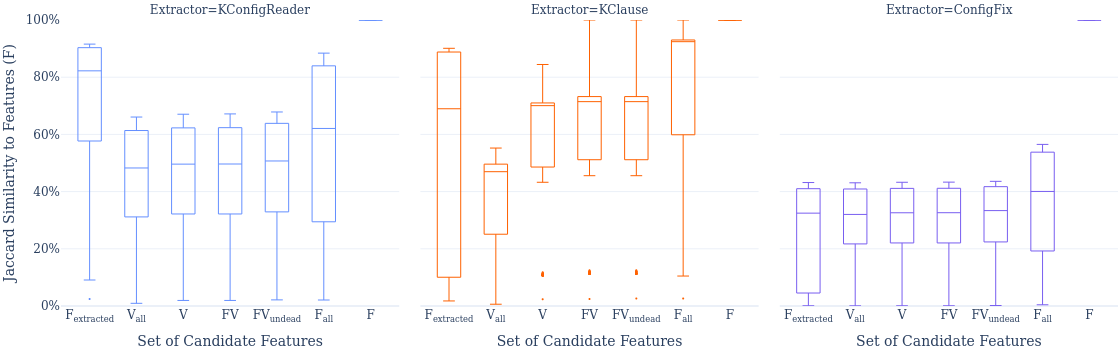

In [245]:

print('extractor comparison:')
print('min=' + str(df_extractor_comparison['jaccard'].min()))
print('median=' + str(df_extractor_comparison['jaccard'].median()))
print('max=' + str(df_extractor_comparison['jaccard'].max()))


df_features_long = pd.melt(
    df_features,
    id_vars=['extractor'],
    value_vars=['extracted_features_jaccard', 'all_variables_jaccard', 'variables_jaccard', \
                'feature_variables_jaccard', 'undead_feature_variables_jaccard', 'all_feature_variables_jaccard', \
                'features_jaccard']
)
df_features_long.replace({'variable': 'extracted_features_jaccard'}, 'F<sub>extracted</sub>', inplace=True)
df_features_long.replace({'variable': 'all_variables_jaccard'}, 'V<sub>all</sub>', inplace=True)
df_features_long.replace({'variable': 'variables_jaccard'}, 'V', inplace=True)
df_features_long.replace({'variable': 'feature_variables_jaccard'}, 'FV', inplace=True)
df_features_long.replace({'variable': 'undead_feature_variables_jaccard'}, 'FV<sub>undead</sub>', inplace=True)
df_features_long.replace({'variable': 'all_feature_variables_jaccard'}, 'F<sub>all</sub>', inplace=True)
df_features_long.replace({'variable': 'features_jaccard'}, 'F', inplace=True)

fig = px.box(
    df_features_long,
    x='variable',
    y='value',
    range_y=[0, 1],
    color='extractor',
    facet_col='extractor',
    labels={'value': 'Jaccard Similarity to Features (F)', 'variable': 'Set of Candidate Features', 'extractor': 'Extractor'},
    category_orders={'variable': ['F<sub>extracted</sub>', 'V<sub>all</sub>', 'V', 'FV', 'FV<sub>undead</sub>', 'F<sub>all</sub>', 'F'],
                     'extractor': ['KConfigReader', 'KClause','ConfigFix']},
)
fig.update_traces(width=0.5)
percentage_y_axis(fig)
style_box(fig, legend_position=None)
show(fig, 'features-jaccard', height=350, width=600, margin=dict(l=0, r=0, t=20, b=0))

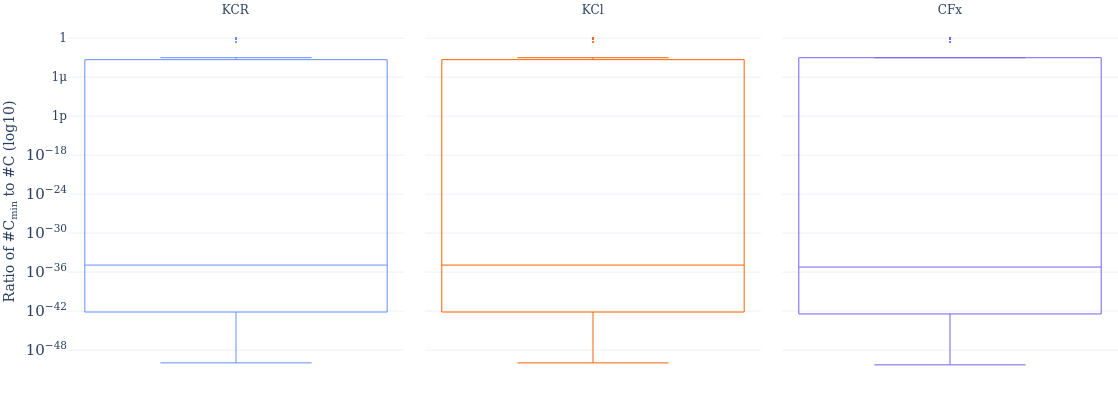

🔍 model-count = 119097789771014208
🔍 unconstrained_bools = 0
🔍 model-count-unconstrained = 119097789771014208
💡 expected model-count-unconstrained = 119097789771014208


In [250]:
all_model_count_dfs = []


for extractor in ['kconfigreader', 'kmax', 'configfixextractor']:
    for system in ['axtls', 'fiasco', 'freetz-ng', 'busybox']:
        try:
            df = read_dataframe(extractor, system, 'solve_model-count', {'model-count': 'string'})
        except Exception as e:
            continue

        if df is None or df.empty:
            
            continue

        df['extractor'] = extractor
        df['system'] = system

        process_model_count(df)  # falls das eine Auswertung ist
        all_model_count_dfs.append(df)

# 📦 Zusammenführen
df_solve = pd.concat(all_model_count_dfs, ignore_index=True)
process_model_count(df_solve)
replace_values(df_solve)
#print(df_solve)
df_features[['extractor', 'system', 'revision', 'unconstrained_bools', 'unconstrained_tristates']].to_csv('/home/rami/Dokumente/data/df1.csv', index=False)
df_solve_unconstrained = df_solve.merge(df_features)

#print(df_solve_unconstrained[['unconstrained_bools', 'unconstrained_tristates']])

df_solve_unconstrained['model-count-unconstrained'] = \
    df_solve_unconstrained.apply(lambda row: \
        str(int(row['model-count']) * (2**int(row['unconstrained_bools'])) * (3**int(row['unconstrained_tristates']))) \
            if not pd.isna(row['model-count']) and row['model-count'] != '' else pd.NA, axis=1)

#print(df_solve_unconstrained)

df_solve_unconstrained['model-count-unconstrained-log10'] = df_solve_unconstrained['model-count-unconstrained'].fillna('').map(big_log10).replace(0, np.nan)
df_solve_unconstrained['similarity'] = df_solve_unconstrained.apply(lambda row: int(row['model-count']) / int(row['model-count-unconstrained']) if not pd.isna(row['model-count']) and row['model-count'] != '' else pd.NA, axis=1)
#print(df_solve_unconstrained)
#df_solve_unconstrained[['similarity']].to_csv('/home/rami/Dokumente/data/similarity_values.csv', index=False)
df_solve_unconstrained[['extractor', 'system', 'revision', 'model-count', 'model-count-unconstrained', 'similarity']].to_csv('/home/rami/Dokumente/data/test3.csv', index=False)

fig = px.box(
    df_solve_unconstrained,
    y='similarity',
    color='extractor',
    facet_col='extractor',
    labels={'similarity': 'Ratio of #C<sub>min</sub> to #C (log10)'},
    log_y=True,
    category_orders={'extractor': ['KConfigReader', 'KClause','ConfigFix']}
)
fig.for_each_annotation(lambda a: a.update(
    text={
        'KConfigReader': 'KCR',
        'KClause': 'KCl',
        'ConfigFix': 'CFx'
    }.get(a.text.split("=")[1], a.text))
)

fig.update_traces(width=0.5)
#fig.update_yaxes(tickvals=[1e0, 1e-3, 1e-6, 1e-9, 1e-12, 1e-15], ticktext=['10<sup>0</sup>', '10<sup>-3</sup>', '10<sup>-6</sup>', '10<sup>-9</sup>', '10<sup>-12</sup>', '10<sup>-15</sup>'])
style_box(fig, legend_position=None)
show(fig, 'configuration-similarity', height=400, width=200, margin=dict(l=0, r=0, t=20, b=0))

df_solve_unconstrained[['extractor', 'system', 'revision', 'model-count', 'model-count-unconstrained', 'similarity']].to_csv('/home/rami/Dokumente/data/debug_model_counts.csv', index=False)
test_row = df_solve_unconstrained[
    (df_solve_unconstrained['system'] == 'axtls') &
    (df_solve_unconstrained['revision'] == 'release-1.0.0') &
    (df_solve_unconstrained['extractor'] == 'KConfigReader')
].iloc[0]

print("🔍 model-count =", test_row['model-count'])
print("🔍 unconstrained_bools =", test_row.get('unconstrained_bools'))
print("🔍 model-count-unconstrained =", test_row['model-count-unconstrained'])

expected = int(test_row['model-count']) * (2 ** int(test_row.get('unconstrained_bools')))
print("💡 expected model-count-unconstrained =", expected)
